In [19]:
# Import base packages
import os
import json
import pickle
import argparse

# Import external packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import InMemoryDataset, Data

In [3]:
# # Read nodes data
paris_100m_nodes = gpd.read_file('https://figshare.com/ndownloader/files/39331691')
paris_100m_nodes = paris_100m_nodes.set_index('osmid')

# # Read edges data
paris_100m_edges = pd.read_csv('https://figshare.com/ndownloader/files/39331688', index_col=0)


KeyError: 'Green view'

In [8]:
paris_100m_nodes['Green View'].head()

osmid
382017        0.185012
3745434708    0.185948
505820718     0.184704
7223004840    0.207488
361709        0.207585
Name: Green View, dtype: float64

In [58]:
paris_100m_edges.plot

<Axes: >

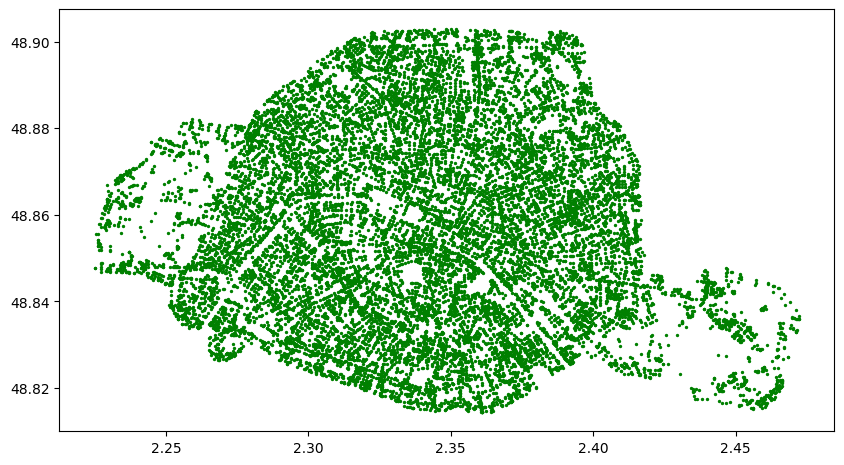

In [59]:
# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))

paris_100m_nodes.plot(ax=ax, color='green', zorder=2, markersize=2)
# paris_100m_edges.plot(ax=ax, linewidth=1, color ='black', zorder=1)



In [15]:
x = np.array(paris_100m_nodes.iloc[:,:-1].values)
x

array([[ 2.3694427 , 48.8215316 , 24.        , ...,  0.10241308,
         0.18397561,  0.07404721],
       [ 2.3693755 , 48.8216647 , 25.        , ...,  0.09919229,
         0.16941237,  0.08053475],
       [ 2.3693568 , 48.8217032 , 26.        , ...,  0.09944842,
         0.16890816,  0.08024358],
       ...,
       [ 2.2920026 , 48.879077  , 32.        , ...,  0.079     ,
         0.2855    ,  0.0655    ],
       [ 2.2888318 , 48.8630926 , 30.        , ...,  0.20785702,
         0.1634444 ,  0.17062246],
       [ 2.4062731 , 48.8786428 , 24.        , ...,  0.1909397 ,
         0.10117333,  0.2406    ]])

In [12]:
X = paris_100m_nodes.drop(columns=['geometry', 'Green View'])
y = paris_100m_nodes['Green View'].values

In [16]:
X = np.array(X.values)
# Standard scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
X_scaled

array([[ 0.5735558 , -1.56397809, -0.26858534, ..., -0.61821728,
        -0.44950728, -1.59782764],
       [ 0.57217202, -1.55803746, -0.17503348, ..., -0.6590187 ,
        -0.54692738, -1.4925691 ],
       [ 0.57178694, -1.5563191 , -0.08148161, ..., -0.65577401,
        -0.55030026, -1.49729327],
       ...,
       [-1.02109693,  1.00443439,  0.47982956, ..., -0.91481718,
         0.22963538, -1.7365036 ],
       [-1.0863903 ,  0.29100582,  0.29272584, ...,  0.71756012,
        -0.58684981, -0.03092217],
       [ 1.33197035,  0.98505483, -0.26858534, ...,  0.50324933,
        -1.00340923,  1.1044431 ]])

In [18]:
# Prepare edge index 
node_to_id = {}
for i, node in enumerate(paris_100m_nodes.index):
    node_to_id[node] = i

start_node = [node_to_id[i] for i in paris_100m_edges['u'].values]
end_node = [node_to_id[i] for i in paris_100m_edges['v'].values]
start = torch.tensor(start_node, dtype=torch.long)
end = torch.tensor(end_node, dtype=torch.long)
edge_index = torch.stack([start, end], dim=0)


In [28]:
# Create dataset for node prediction
class GreenViewDataset(InMemoryDataset):
    def __init__(self, edge_index, x, y, transform=None):
        super(GreenViewDataset, self).__init__('.', transform, None, None)
        
        # Create data object
        data = Data(x=torch.FloatTensor(x), 
                   y=torch.FloatTensor(y), 
                   edge_index=edge_index)
        
        # Set number of nodes and features
        data.num_nodes = x.shape[0]
        data.num_features = x.shape[1]
        
        # Split data into train/val/test sets (70%/15%/15%)
        np.random.seed(0)
        n_nodes = data.num_nodes
        indices = np.random.permutation(n_nodes)
        #print(n_nodes) #debug
        
        train_idx = indices[:int(0.7 * n_nodes)]
        #print(len(train_idx)) #debug
        val_idx = indices[int(0.7 * n_nodes):int(0.85 * n_nodes)]
        test_idx = indices[int(0.85 * n_nodes):]
        
        # Create masks
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True
        
        data.train_mask = train_mask    #size is still all nodes but only True for train nodes
        data.val_mask = val_mask
        data.test_mask = test_mask
        
        self.data, self.slices = self.collate([data])
    
    def _download(self):
        return
    
    def _process(self):
        return
    
    
# Set torch device to cuda if available or else cpu
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = GreenViewDataset(edge_index, X_scaled, y)
data = dataset[0].to(device)

cpu


In [29]:
data.train_

tensor([ True,  True,  True,  ..., False,  True,  True])

18896

In [39]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

# Define hyperparameters
HIDDEN_DIM = 64
LR = 0.01
EPOCHS = 200

class GATv2(torch.nn.Module):
    def __init__(self, hidden_layer, data, output_dim = 1 , heads=4):
        super(GATv2, self).__init__()
        self.gat1 = GATv2Conv(data.num_features, hidden_layer, heads=heads)
        self.gat2 = GATv2Conv(hidden_layer*heads, hidden_layer, heads=1)
        self.linear = nn.Linear(hidden_layer, output_dim)

    def forward(self, data):
        # Get node features and edge index
        x, edge_index = data.x, data.edge_index
        
        # First layer
        out= self.gat1(x, edge_index)
        out = F.elu(out)
        out = F.dropout(out, p= 0.5, training=self.training)
        
        # Second layer
        out = self.gat2(out, edge_index)
        
        # Output layer
        out = self.linear(out)
        
        return out

# Initialise GCN model instance
model = GATv2(HIDDEN_DIM, data).to(device) 
print(model)


GATv2(
  (gat1): GATv2Conv(38, 64, heads=4)
  (gat2): GATv2Conv(256, 64, heads=1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [44]:
# Define loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    # Forward pass
    out = model(data)
    # Compute loss (only on training nodes)
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask]) # squeeze() to remove extra dimension
    # Backward pass
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask].squeeze()
        true = data.y[mask]
        loss = criterion(pred, true)
        
        # Calculate Mean Absolute Error
        mae = torch.mean(torch.abs(pred - true))
    return loss.item(),  mae.item()



In [46]:
# Training loop
best_val_mae = float('inf')
early_stop_counter = 0
early_stop_patience = 30
train_losses, val_losses = [], []

print(f"Starting training on {device}...")
for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss = train()
    train_losses.append(train_loss)
    
    # Evaluate on validation set
    val_loss, val_mae = evaluate(data.val_mask)
    val_losses.append(val_loss)
    
    # Adjust learning rate
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), 'best_green_view_gat.pt')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        
        
    
    # Print progress
    if epoch % 10 == 0:
        test_loss, test_mae = evaluate(data.test_mask)
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val MAE: {val_mae:.4f}, Test Loss: {test_loss:.4f}, ')
        
    # Check for early stopping
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch}")
        break


Starting training on cpu...
Epoch: 010, Train Loss: 0.0253, Val Loss: 0.0135, Val MAE: 0.0913, Test Loss: 0.0139, 
Epoch: 020, Train Loss: 0.0115, Val Loss: 0.0092, Val MAE: 0.0737, Test Loss: 0.0093, 
Epoch: 030, Train Loss: 0.0092, Val Loss: 0.0076, Val MAE: 0.0650, Test Loss: 0.0078, 
Epoch: 040, Train Loss: 0.0070, Val Loss: 0.0058, Val MAE: 0.0566, Test Loss: 0.0059, 
Epoch: 050, Train Loss: 0.0065, Val Loss: 0.0055, Val MAE: 0.0558, Test Loss: 0.0057, 
Epoch: 060, Train Loss: 0.0064, Val Loss: 0.0054, Val MAE: 0.0542, Test Loss: 0.0055, 
Epoch: 070, Train Loss: 0.0062, Val Loss: 0.0053, Val MAE: 0.0535, Test Loss: 0.0054, 
Epoch: 080, Train Loss: 0.0061, Val Loss: 0.0052, Val MAE: 0.0533, Test Loss: 0.0054, 
Epoch: 090, Train Loss: 0.0061, Val Loss: 0.0052, Val MAE: 0.0531, Test Loss: 0.0053, 
Epoch: 100, Train Loss: 0.0060, Val Loss: 0.0051, Val MAE: 0.0527, Test Loss: 0.0053, 
Epoch: 110, Train Loss: 0.0059, Val Loss: 0.0051, Val MAE: 0.0527, Test Loss: 0.0052, 
Epoch: 120, Tra

In [49]:
# Load best model for final evaluation
model.load_state_dict(torch.load('best_green_view_gat.pt'))
test_loss, test_mae = evaluate(data.test_mask)
print(f'Final Test Results - Loss: {test_loss:.4f},  MAE: {test_mae:.4f}')

Final Test Results - Loss: 0.0050,  MAE: 0.0523


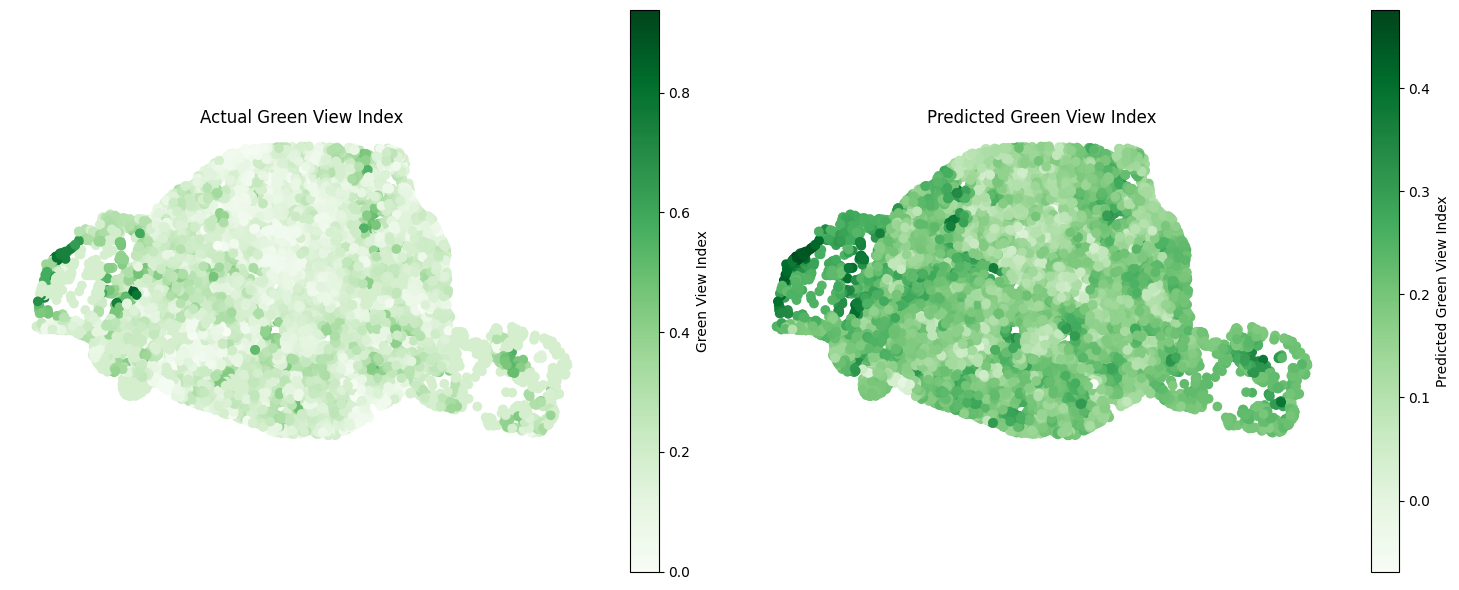

In [50]:
# Generate predictions for all nodes
model.eval()
with torch.no_grad():
    predictions = model(data).squeeze().cpu().numpy()

# Add predictions back to the geodataframe for visualization
paris_100m_nodes['predicted_green_view'] = predictions

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Actual Green View Index
paris_100m_nodes.plot(column='Green View', cmap='Greens', 
                     legend=True, ax=ax1, legend_kwds={'label': "Green View Index"})
ax1.set_title('Actual Green View Index')
ax1.set_axis_off()

# Predicted Green View Index
paris_100m_nodes.plot(column='predicted_green_view', cmap='Greens', 
                     legend=True, ax=ax2, legend_kwds={'label': "Predicted Green View Index"})
ax2.set_title('Predicted Green View Index')
ax2.set_axis_off()

plt.tight_layout()
plt.savefig('green_view_prediction_results.png')
plt.show()

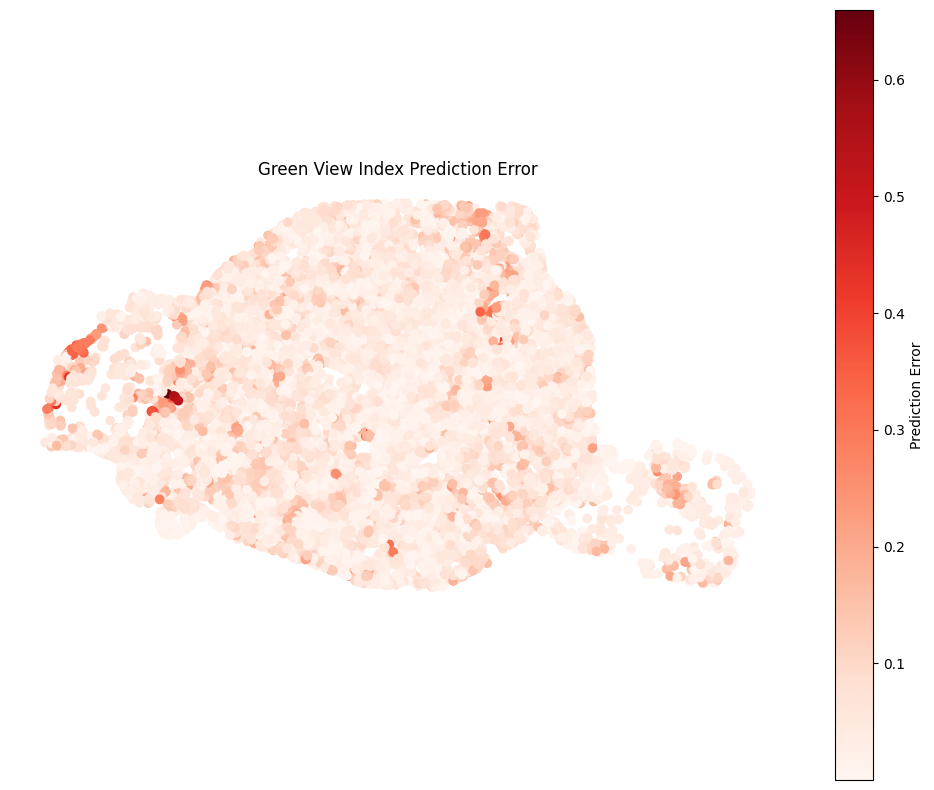

In [60]:

# Also visualize error map
paris_100m_nodes['error'] = np.abs(paris_100m_nodes['Green View'] - predictions)
fig, ax = plt.subplots(figsize=(10, 8))
paris_100m_nodes.plot(column='error', cmap='Reds', 
                    legend=True, ax=ax, legend_kwds={'label': "Prediction Error"})
ax.set_title('Green View Index Prediction Error')
ax.set_axis_off()
plt.tight_layout()
plt.savefig('green_view_prediction_error.png')
plt.show()